# Sonification of Phonon DOS

## Overview

This notebook explores the sonification of phonon data using the [Strauss](https://www.audiouniverse.org/research/strauss) software package. 

Phonons are quantum mechanical quasi-particles which describe the vibrations of atoms in a material. Their spectra (frequencies and energies) can be calculated using a branch of quantum chemistry called Density Functional Theory. We will be reading-in phonon spectra from the [Materials Project](https://next-gen.materialsproject.org/) which holds data on 100,000's of materials.

To run this notebook yourself, or to sonify other Materials Project phonon data, you will need to download the Materials Project API and generate an API key. More details are [here](https://next-gen.materialsproject.org/api).

The animation below shows the motion corresponding to a distortion along one of the "octahedral tilt" phonon modes in material BaZrS$_3$:

<img src="../assets/img/M-mode.gif" width="250" align="center">

Each material has 3N phonon modes, where N is the number of atoms in a unit cell (the repeating cell within the crystal). Each mode corresponds to a range of frequencies (or energies, as determined through $E=h f$). The vibrations across the material can be summarised through a phonon spectra (a.k.a band structure) or density of states. On the LHS of the figure below is the phonon spectra for a different material, tin sulfide (SnS). The x-axis is the crystal momentum, the y-axis is the phonon frequency. On the RHS is the density of states as a function of frequency.

<img src="../assets/img/SnS.jpg" width="750" align="center">

## 1. Setup

In [1]:
%reload_ext autoreload 
%autoreload 2
import sys
import os
sys.path.append('../')
from phonon_sonification import MP_interface
import matplotlib.pyplot as plt
from strauss.sonification import Sonification
from strauss.sources import Events, Objects
from strauss import channels
from strauss.score import Score
from strauss.generator import Spectralizer
import IPython.display as ipd
from scipy.interpolate import interp1d
import numpy as np
import pathlib
%matplotlib inline

## Sonification parameters

In [2]:
# specify audio system (e.g. mono, stereo, 5.1, ...)
system = "stereo"

# length of the sonification in s
length = 10.

## Define functions

`spectralise_dos` reads in dos data, plots the dos data and then calls `spectralise` to sonify.

In [34]:
def play_gamma_modes(mp_id,chem_form,temp=None):
    pass
    # TODO: play gamma mode frequencies as a chord

def get_min_max_frequencies(mp_id_list):
    
    freq_list=[]
    for mp_id in mp_id_list:
        phonon_frequencies, dos = MP_interface.dos_data_from_mp_id(mp_id)
        freq_list.append(phonon_frequencies)

    freq_list = [x for xs in freq_list for x in xs]

    min_freq = min(freq_list)
    if min_freq < 0:
        min_freq=0

    return (min_freq, max(freq_list))  

def spectralise_dos(mp_id,chem_form,freq_lims=None):
    phonon_frequencies, dos = MP_interface.dos_data_from_mp_id(mp_id)
    plt.plot(np.array(phonon_frequencies)/1E12, dos)
    plt.xlabel('frequencies THz')
    plt.ylabel('density of states')
    plt.title(chem_form)
    plt.show()

    if freq_lims:
        min_spectrum = ((min(phonon_frequencies) - freq_lims[0])/(freq_lims[1]-freq_lims[0]))*100
        max_spectrum = ((max(phonon_frequencies) - freq_lims[0])/(freq_lims[1]-freq_lims[0]))*100
    else:
        min_spectrum=0
        max_spectrum=100
        
    spectralise(dos,min_spectrum=0,max_spectrum=max_spectrum)

def spectralise(amplitudes,min_spectrum,max_spectrum):
    notes = [["A2"]]
    
    score =  Score(notes, length)
    
    #set up spectralizer generator
    generator = Spectralizer()
    
    # Lets pick the mapping frequency range for the spectrum...
    generator.modify_preset({'min_freq':100, 'max_freq':5000})
    
    # set up spectrum and choose some envelope parameters for fade-in and fade-out
    data = {'spectrum':[amplitudes], 'pitch':[1], 
            'volume_envelope/D':[0.9], 
            'volume_envelope/S':[0.], 
            'volume_envelope/A':[0.05]}

    print(min_spectrum,max_spectrum)
    # again, use maximal range for the mapped parameters
    lims = {'spectrum': (str(min_spectrum),str(max_spectrum))}
    
    # set up source
    sources = Events(data.keys())
    sources.fromdict(data)
    sources.apply_mapping_functions(map_lims=lims)
    
    # render and play sonification!
    soni = Sonification(score, sources, generator, system)
    soni.render()
    soni.notebook_display(show_waveform=0)


## Cs$_3$Sb

An example of a relatively simple face-centred-cubic structure with no clear phonon gap between optic and acoustic modes. Gives a relatively low pitched white noise.

In [35]:
min_max=get_min_max_frequencies(["mp-10378","mp-569149"])

Retrieving PhononBSDOSDoc documents: 100%|██████| 1/1 [00:00<00:00, 2227.46it/s]


Retrieving PhononBSDOSDoc documents: 100%|█████| 1/1 [00:00<00:00, 10205.12it/s]


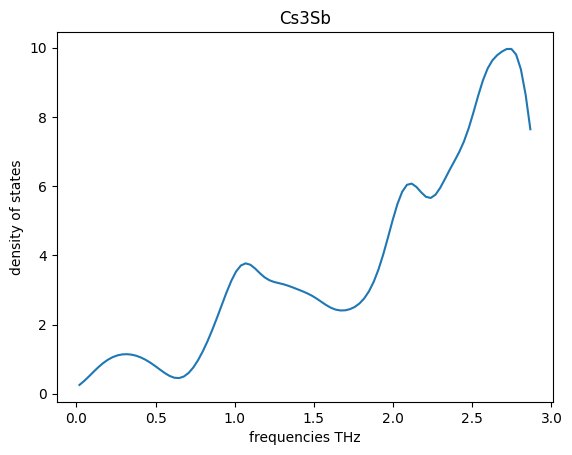

0 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]


In [37]:
spectralise_dos("mp-10378","Cs3Sb")

Listen to the sonification [here](https://NU-CEM.github.io/play_audio?p=https://github.com/NU-CEM/Singing_Materials_Strauss/raw/refs/heads/main/assets/wav/Cs3Sb_DOS.wav).

## K$_2$TeCl$_6$

This is a more complex ternary compound. There is a clear phonon band gap, a larger range of phonon frequencies, and a higher number of peaks. This leads to a more complex sound.

Retrieving PhononBSDOSDoc documents: 100%|█████| 1/1 [00:00<00:00, 11618.57it/s]


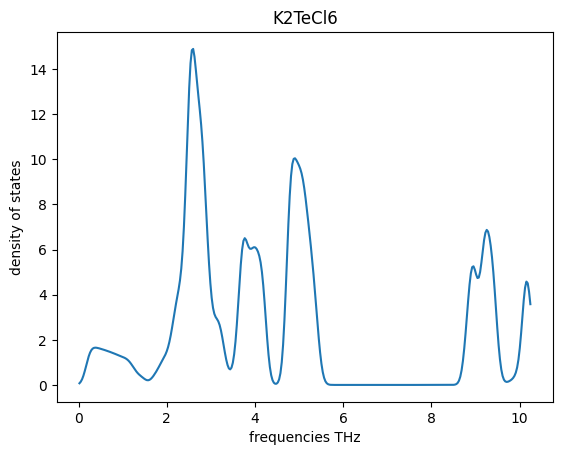

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.93it/s]


In [5]:
spectralise_dos("mp-569149","K2TeCl6")

Listen to the sonification [here](https://NU-CEM.github.io/play_audio?p=https://github.com/NU-CEM/Singing_Materials_Strauss/raw/refs/heads/main/assets/wav/K2TeCl6_DOS.wav).